> Abstract

This project aims to investigate the factors influencing card selection strategies and outcomes in Magic: The Gathering (MTG) drafts. Utilizing a comprehensive dataset from 17lands, an MTG draft tracker, I explore the impact of draft type, player rank, and the sequence of card selections on the probability of cards returning to the drafter in subsequent rounds. Through extensive data cleaning, exploratory analysis, and machine learning modeling, I seek to uncover insights into optimal drafting strategies and the dynamics of the draft process. The findings of this research contribute to a deeper understanding of strategic decision-making in MTG and offer practical implications for players and game designers alike.

> Overview and Motivation

>> Problem Statement

In competitive Magic: The Gathering (MTG), drafting is a strategic format where players select cards in a rotating fashion from a shared pool to construct their decks. The decision-making process involves not only selecting the most advantageous cards for one's own deck but also predicting and influencing the choices of other players to ensure the most beneficial cards return to the drafter in subsequent rounds. This research aims to investigate the extent to which the type of draft, the rank of the player, and the specific cards chosen by pack and pick number can predict the probability of a card returning to the drafter. The overarching question seeks to quantify the impact of these variables on drafting strategy and outcomes, thereby providing insights into the dynamics of draft strategy in MTG.

>> Background

Magic: The Gathering, a trading card game known for its complex strategic depth, offers a unique challenge in the form of drafting. Optimal drafting requires players to possess not only an intimate knowledge of the current card pool but also an understanding of game theory, opponent psychology, and strategic forecasting. Higher-ranked players often have a tangible advantage in drafts due to their superior strategic understanding and ability to anticipate opponents' moves. However, there is a little empirical data to support these anecdotal observations, and the mechanisms through which draft type, player rank, and card selection strategies influence draft outcomes remain poorly understood.

The investigation into these dynamics is not only of academic interest but also of practical significance to the MTG community. While there have been investigations into the game in the past, there is no academic work investigating whether a card will return in a pack. In the way of research, the highest-quality materials are strategy articles written by professional MTG players. While informative, they do not include quantitative data. This research aims to fill that gap by systematically examining how draft type, player rank, and the sequence of card selections influence the draft process. By doing so, it seeks to contribute to a deeper understanding of strategic decision-making in MTG drafts, offering both theoretical insights and practical guidance for players and designers alike.

> Related Work

Highly-regarded MTG draft strategy articles are included below:

- [Drafting 101: Understanding Signals](https://magic.wizards.com/en/news/feature/drafting-101-understanding-signals-2016-04-12)

- [Stark Reality: Drafting the Hard Way](https://www.channelfireball.com/article/Stark-Reality-Drafting-the-Hard-Way/397b71cd-11d4-4644-9e77-5c08846d30c0/)

> Data

Data was downloaded from [17lands public datasets](https://www.17lands.com/public_datasets). Only the links from the DraftData column were downloaded into the data folder. Given this was only a single page with a relatively small amount of links, scraping was deemed unnecessary.

>> Cleaning

The csv file columns were highly complete and without errors. However, different data was collected for different MTG expansions, and the column names don't line up perfectly. display\_combined\_draft\_data was used to combine all the data into a single unified dataset. The joining process converted the csv data from each expansion to a single database, adding Null values as appropriate. Some column names were changed between expansions, which were regularized. There were a few rows that were are Null values, which were deleted. Given that this data only exists in a narrow range, I did not check for outliers. (In MTG drafts, a pool of cards is randomly created from a larger pool of cards for each player. The unusual data would be outlier pick choices, which are very difficult and computationally expensive to find even with a ML model). The only outliers I found were Rank none, Rank None, and Rank 0, which appears to be data for new accounts, but is more unclear than the rest of the data.

>> Storage

I stored the data in a sqlite database in the /data folder.


In [2]:
import sqlite3

def create_or_connect_database(db_name: str = "data/draft_data.db") -> sqlite3.Connection:
    """Create a new SQLite database or connect to an existing one."""
    conn = sqlite3.connect(db_name)
    return conn

def create_draft_data_table(conn: sqlite3.Connection) -> None:
    """Create the draft_data table if it doesn't exist."""
    create_table_sql = """
    CREATE TABLE IF NOT EXISTS draft_data (
        draft_id TEXT,
        draft_time TEXT,
        rank TEXT,
        user_n_games_bucket TEXT,
        user_game_win_rate_bucket TEXT,
        expansion TEXT,
        event_type TEXT,
        event_match_wins INTEGER,
        event_match_losses INTEGER,
        pack_number INTEGER,
        pick_number INTEGER,
        pack_cards TEXT,
        pick TEXT,
        pick_maindeck_rate REAL,
        pick_sideboard_in_rate REAL
    );
    """
    cursor = conn.cursor()
    cursor.execute(create_table_sql)
    conn.commit()

create_draft_data_table(create_or_connect_database())

In [3]:
import os

import numpy as np
import pandas as pd

from tqdm import tqdm

def process_and_save_draft_data(conn: sqlite3.Connection, max_rows_per_file: int | None = None) -> None:
    conn.execute('PRAGMA journal_mode = OFF;')  # Disable journaling
    draft_data_files: list[str] = sorted([file for file in os.listdir("data") if file.endswith('.csv')])
    chunksize: int = 10000  # Define a reasonable chunk size for processing

    for file_name in tqdm(draft_data_files, desc="Processing draft data files"):
        full_path = os.path.join("data", file_name)
        total_rows_processed: int = 0
        for chunk in pd.read_csv(full_path, dtype=str, chunksize=chunksize, nrows=max_rows_per_file):  # Process in chunks
            chunk = chunk.replace({np.nan: None})  # Replace NaN with None for SQL compatibility
            
            # Process pack_cards column
            pack_card_columns = [col for col in chunk.columns if col.startswith('pack_card_')]
            chunk['pack_cards'] = chunk[pack_card_columns].apply(lambda row: '|'.join([col[len('pack_card_'):] for col, value in row.items() if value == '1']), axis=1)
            
            # Drop the original pack_card_ columns
            chunk.drop(columns=pack_card_columns, inplace=True)
            
            # Rename columns to match database schema if necessary
            chunk.rename(columns={
                'user_rank': 'rank',
                'user_n_matches_bucket': 'user_n_games_bucket'
            }, inplace=True, errors='ignore')
            
            # Ensure all schema columns are present in the DataFrame, fill missing ones with None
            schema_columns = [
                'draft_id', 'draft_time', 'rank', 'user_n_games_bucket', 'user_game_win_rate_bucket',
                'expansion', 'event_type', 'event_match_wins', 'event_match_losses', 'pack_number',
                'pick_number', 'pack_cards', 'pick', 'pick_maindeck_rate', 'pick_sideboard_in_rate'
            ]
            for column in schema_columns:
                if column not in chunk.columns:
                    chunk[column] = None
            
            # Keep only the columns that are in the database schema
            chunk = chunk[schema_columns]
            
            # Convert DataFrame to list of tuples for SQL insertion
            rows_to_insert: list[tuple[any, ...]] = [tuple(x) for x in chunk.to_records(index=False)]
            
            # Insert processed rows into the database
            cursor = conn.cursor()
            insert_sql = """
            INSERT INTO draft_data (draft_id, draft_time, rank, user_n_games_bucket, user_game_win_rate_bucket,
            expansion, event_type, event_match_wins, event_match_losses, pack_number, pick_number, pack_cards,
            pick, pick_maindeck_rate, pick_sideboard_in_rate) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """
            try:
                cursor.executemany(insert_sql, rows_to_insert)
                conn.commit()  # Commit after each chunk to manage memory better
            except sqlite3.Error as e:
                print(f"An error occurred: {e}")
                conn.rollback()  # Rollback changes on error
            total_rows_processed += len(chunk)
            if max_rows_per_file is not None and total_rows_processed >= max_rows_per_file:
                break

    delete_sql = "DELETE FROM draft_data WHERE draft_id IS NULL;"
    try:
        cursor = conn.cursor()
        cursor.execute(delete_sql)
        conn.commit()
        print("Rows with draft_id as None have been successfully removed.")
    except sqlite3.Error as e:
        print(f"An error occurred while trying to remove rows with draft_id as None: {e}")
        conn.rollback()

max_rows: int = 20000  # Limited the rows to 100k to save on compute time and prevent crashes due to excessive memory usage
process_and_save_draft_data(create_or_connect_database(), max_rows_per_file=max_rows)

Processing draft data files: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it]


Rows with draft_id as None have been successfully removed.


In [4]:
def create_draft_database(conn):
    cursor = conn.cursor()

    print("Deleting existing draft tables and indices...")
    cursor.execute('DROP TABLE IF EXISTS draft_picks')
    cursor.execute('DROP TABLE IF EXISTS draft_packs')
    cursor.execute('DROP TABLE IF EXISTS draft_wheeling')
    cursor.execute('DROP INDEX IF EXISTS idx_draft_picks_draft_id')
    cursor.execute('DROP INDEX IF EXISTS idx_draft_packs_draft_id')
    cursor.execute('DROP INDEX IF EXISTS idx_draft_wheeling_draft_id')

    print("Creating the draft_picks table...")
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS draft_picks (
        draft_id TEXT,
        expansion TEXT,
        pack_number INTEGER,
        pick_number INTEGER,
        card_name TEXT
    )
    ''')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_draft_picks_draft_id ON draft_picks (draft_id)')

    print("Inserting pick data into the draft_picks table...")
    cursor.execute('''
    INSERT INTO draft_picks (draft_id, expansion, pack_number, pick_number, card_name)
    SELECT draft_id, expansion, pack_number, pick_number, pick
    FROM draft_data
    ''')
    print(f"Number of rows inserted into draft_picks: {cursor.rowcount}")

    print("Creating the draft_packs table...")
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS draft_packs (
        draft_id TEXT,
        expansion TEXT,
        pack_number INTEGER,
        pick_number INTEGER,
        pack_cards TEXT
    )
    ''')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_draft_packs_draft_id ON draft_packs (draft_id)')

    print("Inserting pack data into the draft_packs table...")
    cursor.execute('''
    INSERT INTO draft_packs (draft_id, expansion, pack_number, pick_number, pack_cards)
    SELECT draft_id, expansion, pack_number, pick_number, GROUP_CONCAT(card_name, '|') AS pack_cards
    FROM (
        SELECT draft_id, expansion, pack_number, pick_number, TRIM(value) AS card_name
        FROM draft_data
        CROSS JOIN json_each('["' || REPLACE(pack_cards, '|', '","') || '"]')
    )
    GROUP BY draft_id, expansion, pack_number, pick_number
    ''')
    print(f"Number of rows inserted into draft_packs: {cursor.rowcount}")

    print("Creating the draft_wheeling table...")
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS draft_wheeling (
        draft_id TEXT,
        expansion TEXT,
        pack_number INTEGER,
        pick_number INTEGER,
        pack_cards TEXT,
        wheeled_cards TEXT
    )
    ''')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_draft_wheeling_draft_id ON draft_wheeling (draft_id)')

    print("Inserting wheeling data into the draft_wheeling table...")
    cursor.execute('''
    INSERT INTO draft_wheeling (draft_id, expansion, pack_number, pick_number, pack_cards, wheeled_cards)
    SELECT
        p.draft_id,
        p.expansion,
        p.pack_number,
        p.pick_number,
        p.pack_cards,
        GROUP_CONCAT(w.pack_cards, '|') AS wheeled_cards
    FROM draft_packs p
    LEFT JOIN draft_packs w ON p.draft_id = w.draft_id AND p.expansion = w.expansion AND p.pack_number = w.pack_number AND p.pick_number + 8 = w.pick_number
    GROUP BY p.draft_id, p.expansion, p.pack_number, p.pick_number
    ''')
    print(f"Number of rows inserted into draft_wheeling: {cursor.rowcount}")

    print("Optimizing the database by running ANALYZE...")
    cursor.execute('ANALYZE')

    print("Committing the changes...")
    conn.commit()

    print("Database creation and data insertion completed.")

create_draft_database(create_or_connect_database())

Deleting existing draft tables and indices...
Creating the draft_picks table...
Inserting pick data into the draft_picks table...
Number of rows inserted into draft_picks: 2470000
Creating the draft_packs table...
Inserting pack data into the draft_packs table...
Number of rows inserted into draft_packs: 600000
Creating the draft_wheeling table...
Inserting wheeling data into the draft_wheeling table...
Number of rows inserted into draft_wheeling: 600000
Optimizing the database by running ANALYZE...
Committing the changes...
Database creation and data insertion completed.


In [5]:
def load_data_from_db(conn: sqlite3.Connection) -> pd.DataFrame:
    print(f"Loading data from database")
    df = pd.read_sql_query("SELECT * FROM draft_wheeling", conn)
    print(f"Dataframe shape: {df.shape}")

    return df

def preprocess_data(df: pd.DataFrame) -> tuple[pd.DataFrame, set]:
    print("Preprocessing data...")

    print(df.head())

    # Handle NaN values in pack_cards
    df['pack_cards'] = df['pack_cards'].apply(lambda x: [] if pd.isna(x) else x)

    def split_cards(x):
        if isinstance(x, str):
            return x.split('|')
        else:
            print(f"Warning: Found non-string value in pack_cards: {x}")
            return []

    df['pack_cards'] = df['pack_cards'].apply(split_cards)

    # Create a set of unique cards
    unique_cards = set(card for pack in tqdm(df['pack_cards'], desc="Collecting unique cards") for card in pack)

    # Create a dictionary to map each unique card to an index
    card_to_index = {card: i for i, card in enumerate(unique_cards)}

    # Convert pack_cards to a bag-of-words representation
    def pack_to_bow(pack):
        bow = [0] * len(unique_cards)
        for card in pack:
            index = card_to_index[card]
            bow[index] += 1
        return bow

    df['pack_bow'] = df['pack_cards'].apply(pack_to_bow)

    # Handle NULL values in wheeled_cards
    df['wheeled_cards'] = df['wheeled_cards'].apply(lambda x: x.split('|') if x is not None else [])

    print("Dataframe after preprocessing:")
    print(df.head())
    return df, unique_cards

df = load_data_from_db(create_or_connect_database())
df, unique_cards = preprocess_data(df)

Loading data from database
Dataframe shape: (600000, 6)
Preprocessing data...
                           draft_id expansion  pack_number  pick_number  \
0  000242c42c184402bbbbb9517cb127cf       AFR            0            1   
1  000242c42c184402bbbbb9517cb127cf       AFR            0            2   
2  000242c42c184402bbbbb9517cb127cf       AFR            0            3   
3  000242c42c184402bbbbb9517cb127cf       AFR            0            4   
4  000242c42c184402bbbbb9517cb127cf       AFR            0            5   

                                          pack_cards  \
0  Arcane Investigator|Bar the Gate|Delver's Torc...   
1  +2 Mace|Arborea Pegasus|Bar the Gate|Clatterin...   
2  Baleful Beholder|Dire Wolf Prowler|Djinni Wind...   
3  Air-Cult Elemental|Fates' Reversal|Goblin Jave...   
4  Bag of Holding|Dawnbringer Cleric|Devoted Pala...   

                                       wheeled_cards  
0  Bar the Gate|Dragon's Disciple|Half-Elf Monk|L...  
1  +2 Mace|Devour Intell

Dataframe after preprocessing:
                           draft_id expansion  pack_number  pick_number  \
0  000242c42c184402bbbbb9517cb127cf       AFR            0            1   
1  000242c42c184402bbbbb9517cb127cf       AFR            0            2   
2  000242c42c184402bbbbb9517cb127cf       AFR            0            3   
3  000242c42c184402bbbbb9517cb127cf       AFR            0            4   
4  000242c42c184402bbbbb9517cb127cf       AFR            0            5   

                                          pack_cards  \
0  [Arcane Investigator, Bar the Gate, Delver's T...   
1  [+2 Mace, Arborea Pegasus, Bar the Gate, Clatt...   
2  [Baleful Beholder, Dire Wolf Prowler, Djinni W...   
3  [Air-Cult Elemental, Fates' Reversal, Goblin J...   
4  [Bag of Holding, Dawnbringer Cleric, Devoted P...   

                                       wheeled_cards  \
0  [Bar the Gate, Dragon's Disciple, Half-Elf Mon...   
1  [+2 Mace, Devour Intellect, Scaled Herbalist, ...   
2  [Dire Wolf

> Final Research Question

To what extent can the specific cards chosen by pack and pick number predict the probability of a card returning to the drafter in subsequent rounds of a Magic: The Gathering draft?

The main hypothesis is:

H1: The sequence of card selections will have a significant impact on the probability of a card wheeling back to the drafter.

The null hypothesis is:

H0: There is no relationship between ard selection order and the likelihood of a card returning to the drafter.

> Final Analysis

>> Exploratory Data Analysis

In [6]:
from prettytable import PrettyTable

def print_first_n_entries_from_db_sorted_by_expansion(conn: sqlite3.Connection, n: int = 100) -> None:
    """Print the first n entries from the draft_data table, sorted by expansion, limited to n per expansion."""
    select_sql = """
    SELECT * FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY expansion ORDER BY draft_id) as rn
        FROM draft_data
    ) WHERE rn <= ?
    ORDER BY expansion;
    """
    cursor = conn.cursor()
    cursor.execute(select_sql, (n,))
    rows = cursor.fetchall()
    
    if rows:
        table = PrettyTable()
        table.field_names = [description[0] for description in cursor.description]
        for row in rows:
            table.add_row(row)
        print(table)
    else:
        print("No data found.")

print_first_n_entries_from_db_sorted_by_expansion(create_or_connect_database(), n=5)

+----------------------------------+---------------------+----------+---------------------+---------------------------+-----------+--------------+------------------+--------------------+-------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+--------------------+------------------------+----+
|             draft_id             |      draft_time     |   rank   | user_n_games_bucket | user_game_win_rate_bucket | expansion |  event_type  | event_match_wins | event_match_losses | pack_number | pick_number |                                                                                                                                                    pack_cards                      

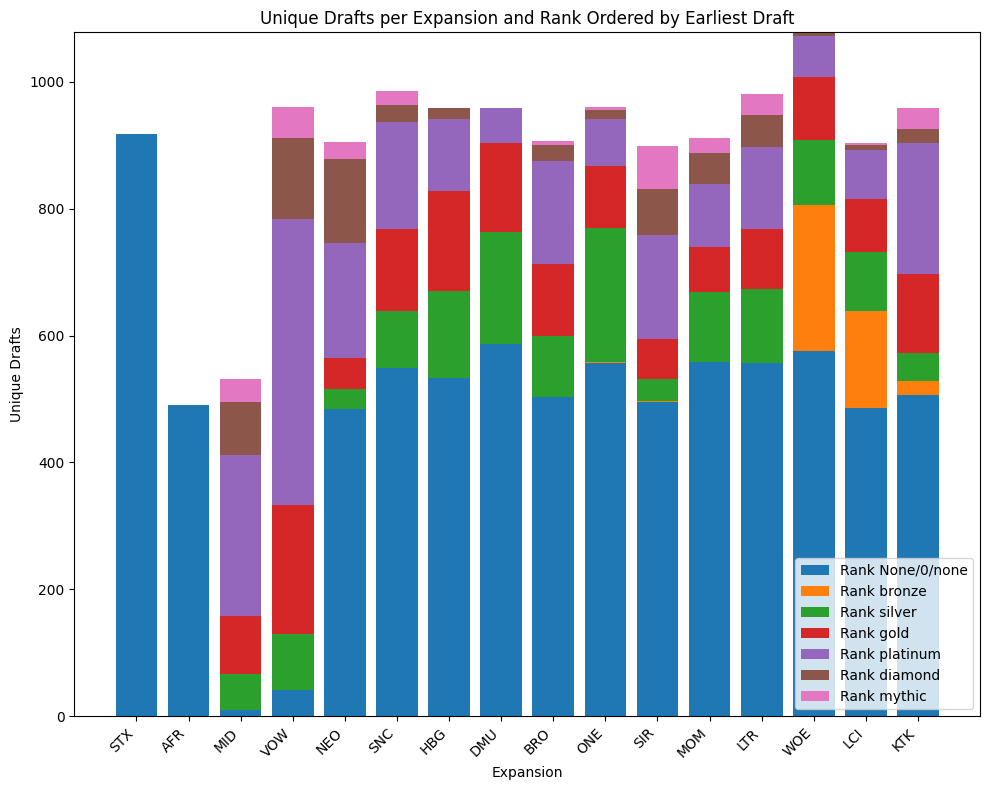

In [7]:
import matplotlib.pyplot as plt

def get_expansion_order_by_earliest_draft(conn: sqlite3.Connection) -> list[str]:
    """Retrieve expansions ordered by the earliest draft time."""
    select_sql = """
    SELECT expansion
    FROM draft_data
    GROUP BY expansion
    ORDER BY MIN(draft_time);
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    return [expansion[0] for expansion in rows]

def count_unique_drafts_per_expansion_and_rank(conn: sqlite3.Connection) -> dict[str, dict[str, int]]:
    """Counts the number of unique draft ids for each expansion and rank, returns a nested dictionary."""
    select_sql = """
    SELECT expansion, rank, COUNT(DISTINCT draft_id) AS unique_drafts
    FROM draft_data
    GROUP BY expansion, rank;
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    draft_counts: dict[str, dict[str, int]] = {}
    for expansion, rank, count in rows:
        draft_counts.setdefault(expansion, {})[rank] = count
    
    return draft_counts

def visualize_draft_counts_by_rank(conn: sqlite3.Connection) -> None:
    """Visualize the number of unique drafts per expansion and rank using a stacked bar chart, ordered by the earliest draft time."""
    draft_counts = count_unique_drafts_per_expansion_and_rank(conn)
    expansion_order = get_expansion_order_by_earliest_draft(conn)
    
    # Preparing data for stacked bar chart
    rank_order = ['None', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    expansions = expansion_order
    bottom = np.zeros(len(expansions))
    
    plt.figure(figsize=(10, 8))
    
    # Combining 'None', '0', and 'none' into a single point for visualization
    for rank in rank_order:
        if rank == 'None':
            counts = [draft_counts[expansion].get(None, 0) + draft_counts[expansion].get('0', 0) + draft_counts[expansion].get('none', 0) for expansion in expansions]
        else:
            counts = [draft_counts[expansion].get(rank, 0) for expansion in expansions]
        plt.bar(expansions, counts, bottom=bottom, label=f'Rank {rank}' if rank != 'None' else 'Rank None/0/none')
        bottom += np.array(counts)
    
    plt.xlabel('Expansion')
    plt.ylabel('Unique Drafts')
    plt.title('Unique Drafts per Expansion and Rank Ordered by Earliest Draft')
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_draft_counts_by_rank(create_or_connect_database())

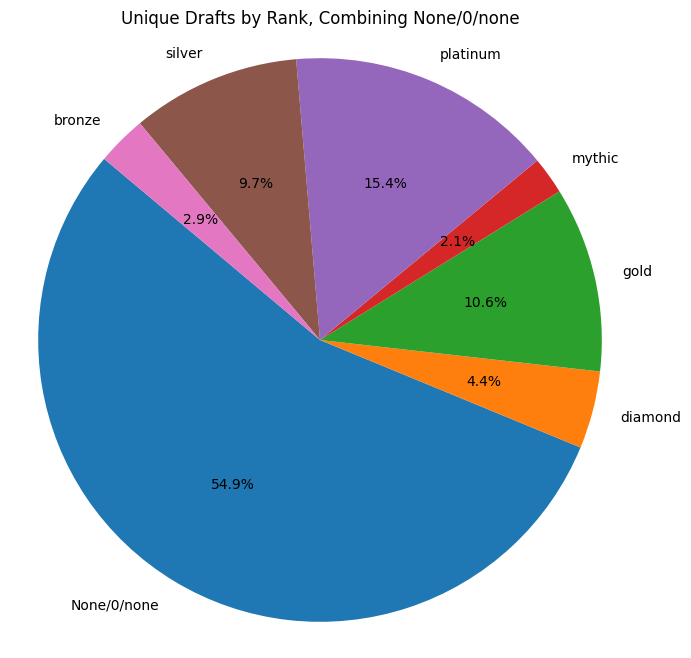

In [8]:
def visualize_draft_counts_by_rank_pie_chart(conn: sqlite3.Connection) -> None:
    """Visualize the number of unique drafts per rank using a pie chart, combining 'none', '0', and 'None' into a single category."""
    draft_counts = count_unique_drafts_per_expansion_and_rank(conn)
    
    # Aggregating counts by rank across all expansions, combining 'none', '0', and 'None'
    total_counts_by_rank: dict[str, int] = {}
    for expansion, ranks in draft_counts.items():
        for rank, count in ranks.items():
            if rank in ['none', '0', None]:
                total_counts_by_rank['None/0/none'] = total_counts_by_rank.get('None/0/none', 0) + count
            else:
                total_counts_by_rank[rank] = total_counts_by_rank.get(rank, 0) + count
    
    # Preparing data for pie chart
    labels = list(total_counts_by_rank.keys())
    sizes = list(total_counts_by_rank.values())
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Unique Drafts by Rank, Combining None/0/none')
    plt.show()

visualize_draft_counts_by_rank_pie_chart(create_or_connect_database())


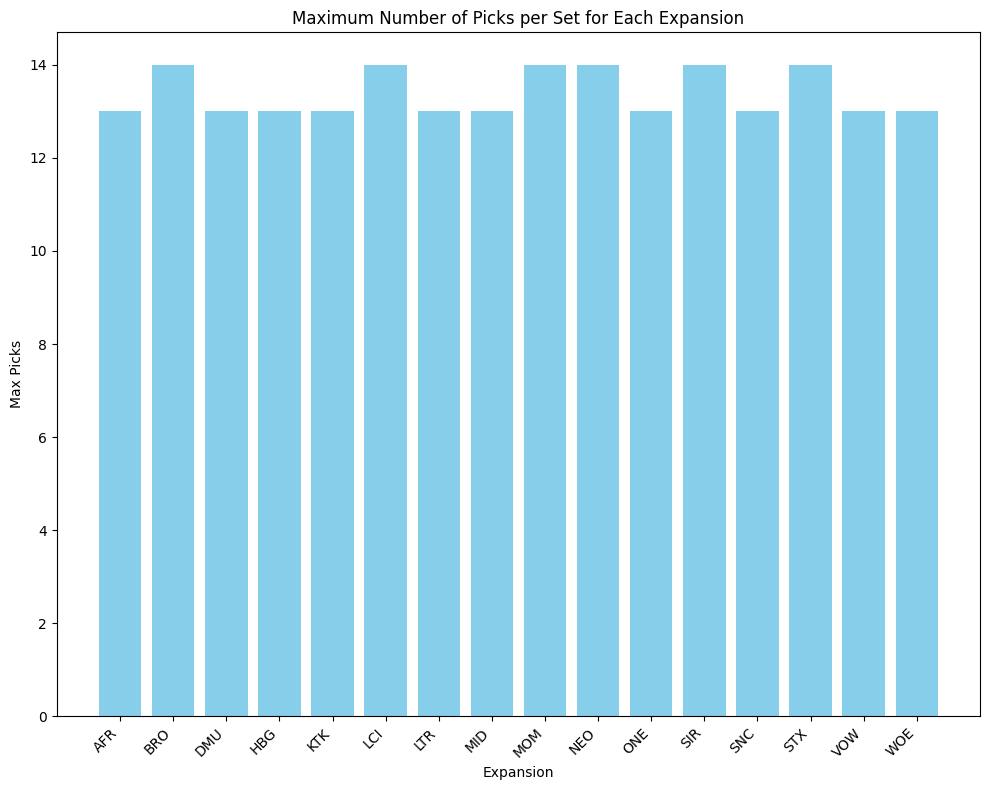

In [9]:
def visualize_picks_per_set(conn: sqlite3.Connection) -> None:
    """Visualize the maximum number of picks per set for each expansion."""
    select_sql = """
    SELECT expansion, MAX(pick_number) AS max_picks
    FROM draft_data
    GROUP BY expansion;
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    expansions: list[str] = []
    max_picks: list[int] = []
    for expansion, max_pick in rows:
        expansions.append(expansion)
        max_picks.append(max_pick)
    
    plt.figure(figsize=(10, 8))
    plt.bar(expansions, max_picks, color='skyblue')
    plt.xlabel('Expansion')
    plt.ylabel('Max Picks')
    plt.title('Maximum Number of Picks per Set for Each Expansion')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

visualize_picks_per_set(create_or_connect_database())

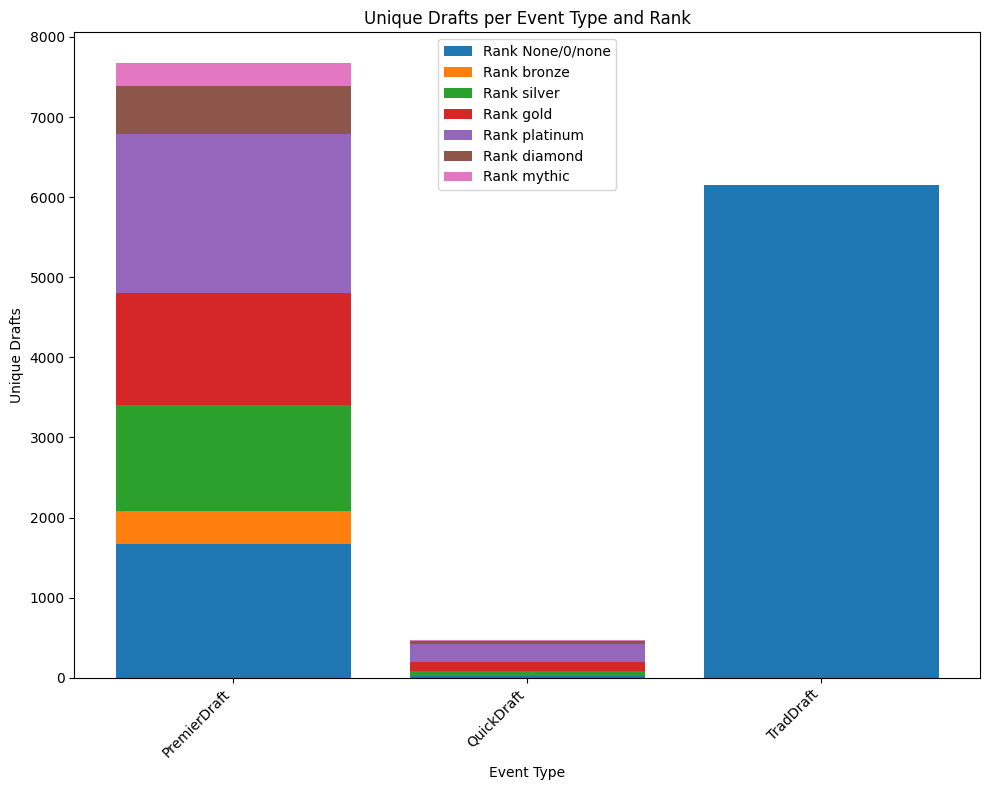

In [10]:
def visualize_event_types_by_rank(conn: sqlite3.Connection) -> None:
    """Visualize unique draft_ids per event type, categorized by rank."""
    select_sql = """
    SELECT event_type, rank, COUNT(DISTINCT draft_id) AS unique_drafts
    FROM draft_data
    GROUP BY event_type, rank;
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    event_types: list[str] = []
    rank_order: list[str] = ['None', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    event_data: dict[str, dict[str, int]] = {}
    
    for event_type, rank, unique_drafts in rows:
        if event_type not in event_types:
            event_types.append(event_type)
        if event_type not in event_data:
            event_data[event_type] = {}
        event_data[event_type][rank] = unique_drafts
    
    # Combining 'None', '0', and 'none' into a single category
    for event_type in event_data:
        event_data[event_type]['None'] = event_data[event_type].get(None, 0) + event_data[event_type].get('0', 0) + event_data[event_type].get('none', 0)
        if '0' in event_data[event_type]:
            del event_data[event_type]['0']
        if 'none' in event_data[event_type]:
            del event_data[event_type]['none']
    
    plt.figure(figsize=(10, 8))
    bottom = np.zeros(len(event_types))
    for rank in rank_order:
        counts = [event_data[event_type].get(rank, 0) for event_type in event_types]
        plt.bar(event_types, counts, bottom=bottom, label=f'Rank {rank}' if rank != 'None' else 'Rank None/0/none')
        bottom += np.array(counts)
    
    plt.xlabel('Event Type')
    plt.ylabel('Unique Drafts')
    plt.title('Unique Drafts per Event Type and Rank')
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_event_types_by_rank(create_or_connect_database())

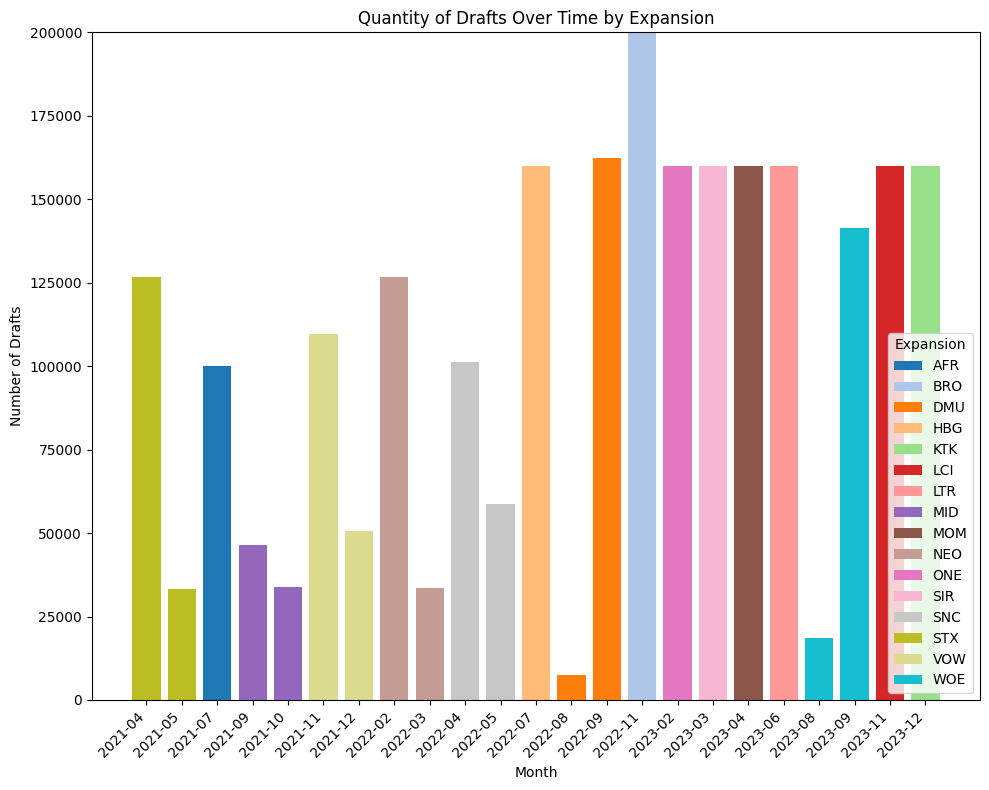

In [11]:
def plot_drafts_over_time_by_expansion(conn: sqlite3.Connection) -> None:
    """Plot the quantity of drafts over time, colored by expansion."""
    select_sql = """
    SELECT strftime('%Y-%m', draft_time) AS month, expansion, COUNT(draft_id) AS draft_count
    FROM draft_data
    GROUP BY month, expansion
    ORDER BY month, expansion;
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    months: list[str] = []
    expansions: set[str] = set()
    draft_data: dict[str, dict[str, int]] = {}
    
    for month, expansion, draft_count in rows:
        if month not in months:
            months.append(month)
        expansions.add(expansion)
        if month not in draft_data:
            draft_data[month] = {}
        draft_data[month][expansion] = draft_count
    
    # Preparing data for plotting
    expansion_colors = {
        expansion: plt.cm.tab20(i/len(expansions)) for i, expansion in enumerate(sorted(expansions))
    }
    
    plt.figure(figsize=(10, 8))
    bottom = np.zeros(len(months))
    for expansion in sorted(expansions):
        counts = [draft_data[month].get(expansion, 0) for month in months]
        plt.bar(months, counts, bottom=bottom, label=expansion, color=expansion_colors[expansion])
        bottom += np.array(counts)
    
    plt.xlabel('Month')
    plt.ylabel('Number of Drafts')
    plt.title('Quantity of Drafts Over Time by Expansion')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Expansion')
    plt.tight_layout()
    plt.show()

plot_drafts_over_time_by_expansion(create_or_connect_database())

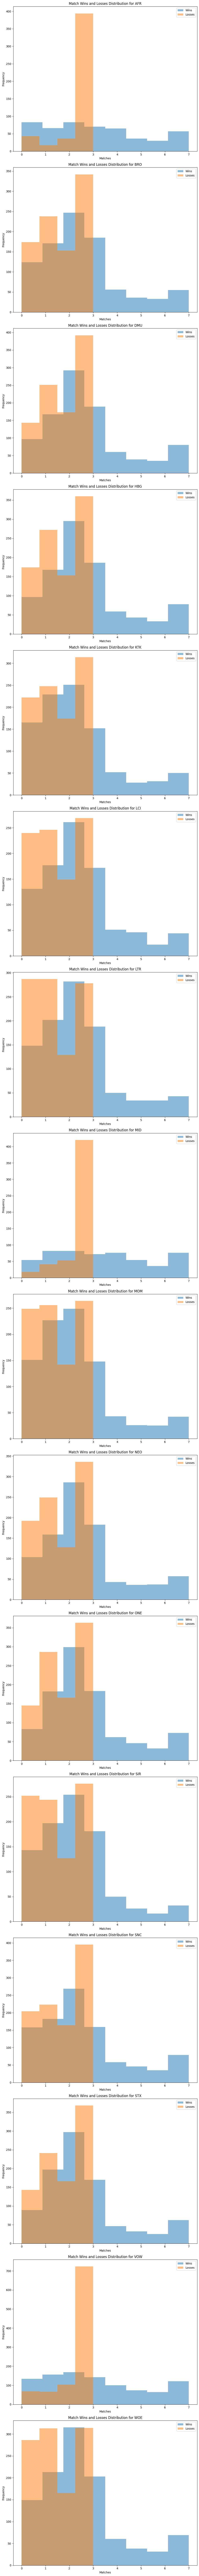

In [12]:
def plot_match_wins_losses_distribution(conn: sqlite3.Connection) -> None:
    """Plot the distribution of match wins and losses for each expansion, considering only unique draft ids."""
    select_sql = """
    SELECT DISTINCT draft_id, expansion, event_match_wins, event_match_losses
    FROM draft_data
    WHERE event_match_wins IS NOT NULL AND event_match_losses IS NOT NULL
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    expansion_data: dict[str, list[tuple[int, int]]] = {}
    for _, expansion, wins, losses in rows:
        if expansion not in expansion_data:
            expansion_data[expansion] = []
        expansion_data[expansion].append((wins, losses))
    
    # Plotting
    fig, axs = plt.subplots(len(expansion_data), 1, figsize=(10, 8 * len(expansion_data)))
    if len(expansion_data) == 1:
        axs = [axs]
    for ax, (expansion, matches) in zip(axs, expansion_data.items()):
        wins, losses = zip(*matches)
        ax.hist(wins, bins=max(wins) - min(wins) + 1, alpha=0.5, label='Wins')
        ax.hist(losses, bins=max(losses) - min(losses) + 1, alpha=0.5, label='Losses')
        ax.set_title(f'Match Wins and Losses Distribution for {expansion}')
        ax.set_xlabel('Matches')
        ax.set_ylabel('Frequency')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_match_wins_losses_distribution(create_or_connect_database())

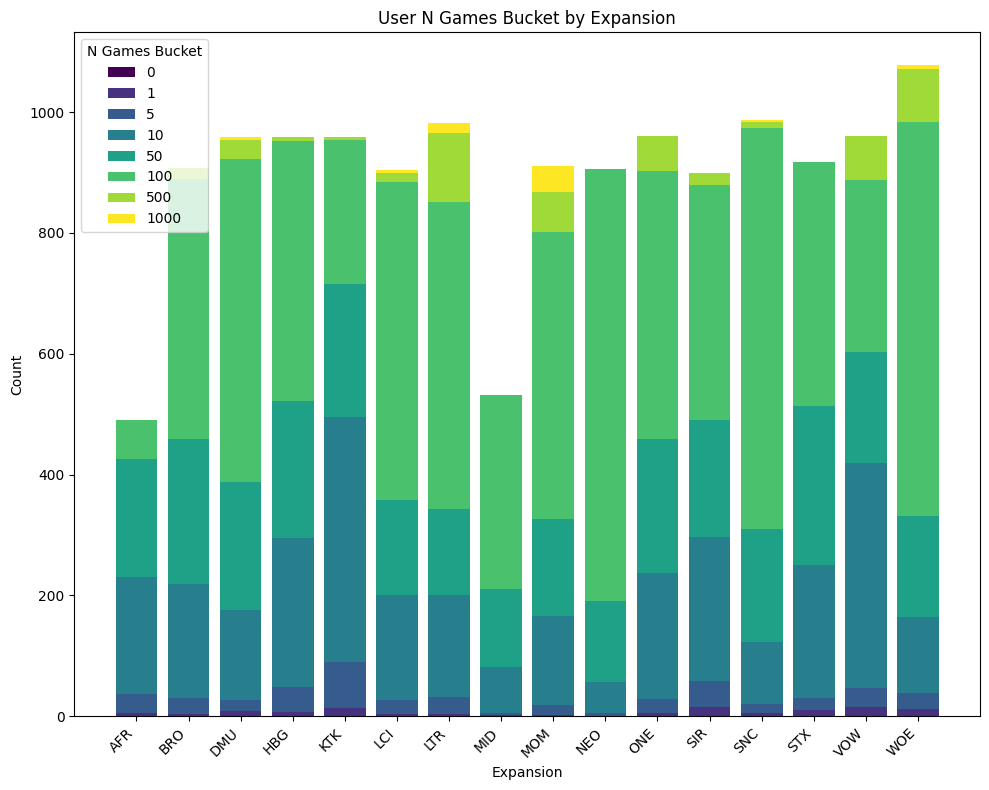

In [13]:
def plot_user_n_games_bucket_by_expansion(conn: sqlite3.Connection) -> None:
    """Plot user_n_games_bucket by expansion in a bar chart, separating by different game numbers, considering unique draft ids."""
    select_sql = """
    SELECT expansion, user_n_games_bucket, COUNT(DISTINCT draft_id) as count
    FROM draft_data
    GROUP BY expansion, user_n_games_bucket
    ORDER BY expansion, user_n_games_bucket
    """
    cursor = conn.cursor()
    cursor.execute(select_sql)
    rows = cursor.fetchall()
    
    expansion_data: dict[str, dict[str, int]] = {}
    for expansion, games_bucket, count in rows:
        if expansion not in expansion_data:
            expansion_data[expansion] = {}
        # Treat None values as '0' and ensure all buckets are treated as strings
        games_bucket_str = str(int(games_bucket)) if games_bucket is not None else '0'
        expansion_data[expansion][games_bucket_str] = count
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_buckets = sorted({games_bucket for _, games_bucket, _ in rows if games_bucket is not None}, key=int)
    unique_buckets = ['0'] + [str(bucket) for bucket in unique_buckets]  # Ensure '0' is included and all buckets are strings
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_buckets)))
    bottom = np.zeros(len(expansion_data))
    
    for games_bucket, color in zip(unique_buckets, colors):
        counts = [expansion_data[expansion].get(games_bucket, 0) for expansion in sorted(expansion_data)]
        label = games_bucket  # Use the string representation directly
        ax.bar(sorted(expansion_data.keys()), counts, bottom=bottom, color=color, label=label)
        bottom += np.array(counts)
    
    ax.set_title('User N Games Bucket by Expansion')
    ax.set_xlabel('Expansion')
    ax.set_ylabel('Count')
    ax.legend(title='N Games Bucket', loc='best', ncol=1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_user_n_games_bucket_by_expansion(create_or_connect_database())

> Model Creation

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import joblib
import time

def train_random_forest(df: pd.DataFrame, unique_cards: set[str], save: bool = True) -> RandomForestClassifier:
    """
    Trains a Random Forest model to predict whether cards will be wheeled based on their bag-of-words representation.

    Args:
    df (pd.DataFrame): The dataframe containing the training data.
    unique_cards (set[str]): A set of unique cards used to index the bag-of-words.

    Returns:
    RandomForestClassifier: The trained Random Forest model.
    """
    print("Training Random Forest model...")
    X = df['pack_bow'].tolist()
    y = df['wheeled_cards'].apply(lambda x: 1 if len(x) > 0 else 0).tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(random_state=42)
    print("Fitting the model...")
    clf.fit(X_train, y_train)

    # Save the trained model and the unique_cards list
    if save:
        print("Saving the model and unique_cards...")
        joblib.dump(clf, 'draft_wheeling_model.pkl')
        joblib.dump(unique_cards, 'unique_cards.pkl')

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return clf

def predict_wheeling(model: RandomForestClassifier, unique_cards: set[str], current_pack: str) -> int:
    """
    Predicts the wheeling of a card based on the current pack's representation.

    Args:
    model (RandomForestClassifier): The trained Random Forest model.
    unique_cards (set[str]): A set of unique cards used to index the bag-of-words.
    current_pack (str): A string representation of the current pack of cards.

    Returns:
    int: The prediction result (1 for wheeled, 0 for not wheeled).
    """
    print("Predicting wheeling...")
    # Convert current_pack to a bag-of-words representation
    card_to_index = {card: i for i, card in enumerate(unique_cards)}
    pack_bow = [0] * len(unique_cards)
    for card in current_pack.split('|'):
        if card in card_to_index:
            index = card_to_index[card]
            pack_bow[index] += 1

    prediction = model.predict([pack_bow])
    print(f"Prediction: {prediction[0]}")
    return prediction[0]

# Train the model
model = train_random_forest(df, unique_cards)
loaded_model = joblib.load('draft_wheeling_model.pkl')

Training Random Forest model...
Fitting the model...
Saving the model and unique_cards...
Accuracy: 0.8646
Precision: 0.9070
Recall: 0.7712
F1-score: 0.8337


> Full Analysis

Even with a very limited amount of data per set, the results of the Random Forest Classifier are promising. It reached an accuracy of 86.46%, precision of 90.70%, recall of 77.12%, and a F1-score of 83.37% on the test set. These metrics provide a comprehensive understanding of the model's performance in the binary classification task. Accuracy gives an overall measure of correctness, while precision and recall help evaluate the model's performance on the positive class (wheeled cards). The F1-score combines precision and recall into a single metric, making it easier to compare different models.

The high scores achieved by the Random Forest classifier were a pleasant surprise, especially considering that this is using a small subset of the available features. The model's performance can likely be attributed to the fact that we are focusing on limited amount of MTG data, and certain cards are significantly stronger or weaker than others. This inherent imbalance in card power may make it easier for the model to identify patterns and predict wheeling probabilities.

Even given these limitations, it is clear that MTG draft wheeling *can* be predicted by a ML model, even with low amounts of data per set. There is evidence to show that the hypothesis that card selection order is related to what cards wheel may be true.